In [20]:
%load_ext autoreload
%autoreload 2
import sys
import os
import random

import numpy as np
import pandas as pd
import scipy
import uproot
import hist

sys.path.append("../../..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId
from hists.dataframe import DataframeComputations
from event_visualizer.event_index import EventLoader
from event_visualizer.notebook_visualizer import EventDisplay

from selections import *
from plot import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v40'
#clueParams = "single-file"
clueParams = "cmssw"
datatype = "data"

In [4]:
clueClustersFile = os.path.join(hist_folder, clueParams, datatype, "CLUE_clusters.root")
tree = uproot.open(clueClustersFile + ":clusters")
eventLoader = EventLoader(clueClustersFile)

In [5]:
comp = DataframeComputations(tree.arrays(cut="beamEnergy == 20",
    filter_name=["beamEnergy", "event", "ntupleNumber", "rechits_energy", "rechits_layer"]), rechits_columns=["rechits_energy", "rechits_layer"])
energySumPerLayer_df = (comp
    .rechits_totalReconstructedEnergyPerEventLayer_allLayers(joinWithBeamEnergy=False)
    .set_index("rechits_layer", append=True)
)
energySumPerLayer_df = energySumPerLayer_df.join(energySumPerLayer_df
            .groupby(by="eventInternal")
            .agg(
                rechits_energy_sum=pd.NamedAgg(column="rechits_energy_sum_perLayer", aggfunc="sum"),
            ))
energySumPerLayer_df

rechits_energy_sum_perLayer  rechits_energy_sum
eventInternal rechits_layer                                                 
0             1                                 0.150613           20.515938
              2                                 0.698109           20.515938
              3                                 0.994358           20.515938
              4                                 0.918104           20.515938
              5                                 1.715502           20.515938
...                                                  ...                 ...
19432         24                                0.025358           20.128302
              25                                0.000000           20.128302
              26                                0.006117           20.128302
              27                                0.008391           20.128302
              28                                0.004375           20.128302

[544124 rows x 2 columns]

In [6]:
maximas_df = computeMaximasDf(energySumPerLayer_df, order=3)

In [7]:
energySumPerLayer_df.pipe(addInfo, comp).query("event==7551 and ntupleNumber==674")

,,rechits_energy_sum_perLayer,rechits_energy_sum,ntupleNumber,event,beamEnergy
eventInternal,rechits_layer,,,,,


In [8]:
df = pd.DataFrame(energySumPerLayer_df).pipe(addInfo, comp)
#df[df.event == 7319]
df[(df.ntupleNumber == 455) & (np.abs(df.event - 7319) < 20)]

rechits_energy_sum_perLayer  rechits_energy_sum   
eventInternal rechits_layer                                                    
18433         1                                 0.183375           18.630188  \
              2                                 0.545992           18.630188   
              3                                 0.965542           18.630188   
              4                                 1.414302           18.630188   
              5                                 1.813441           18.630188   
...                                                  ...                 ...   
18436         24                                0.000000           18.858604   
              25                                0.000000           18.858604   
              26                                0.020379           18.858604   
              27                                0.000000           18.858604   
              28                                0.000000           18.858604   

                             ntupleNumber  event  beamEnergy  
eventInternal rechits_layer                                   
18433         1                       455   7319        20.0  
              2                       455   7319        20.0  
              3                       455   7319        20.0  
              4                       455   7319        20.0  
              5                       455   7319        20.0  
...                                   ...    ...         ...  
18436         24                      455   7338        20.0  
              25                      455   7338        20.0  
              26                      455   7338        20.0  
              27                      455   7338        20.0  
              28                      455   7338        20.0  

[112 rows x 5 columns]

In [9]:
energySumPerLayer_df

rechits_energy_sum_perLayer  rechits_energy_sum
eventInternal rechits_layer                                                 
0             1                                 0.150613           20.515938
              2                                 0.698109           20.515938
              3                                 0.994358           20.515938
              4                                 0.918104           20.515938
              5                                 1.715502           20.515938
...                                                  ...                 ...
19432         24                                0.025358           20.128302
              25                                0.000000           20.128302
              26                                0.006117           20.128302
              27                                0.008391           20.128302
              28                                0.004375           20.128302

[544124 rows x 2 columns]

In [10]:
cut_df = (cutOnFractionOfMaxLayerEnergy(maximas_df, energySumPerLayer_df, fractionOfMaxLayerEnergy=0)
    .pipe(selectTwoHighestMaxima)
    .pipe(unstackTwoLevels)
    .pipe(addInfo, comp)
    #.pipe(filterLowEnergyEvents)
)
cut_df

,rechits_energy_sum_perLayer_maxPerEvent,rechits_energy_sum,rechits_energy_sum_perLayer_0,rechits_energy_sum_perLayer_1,maximaLayer_0,maximaLayer_1,ntupleNumber,event,beamEnergy
eventInternal,,,,,,,,,
1,2.561388,19.885166,2.561388,NaN,7.0,NaN,436,2472,20.0
2,2.277482,19.483814,2.277482,0.953469,6.0,17.0,436,2474,20.0
4,2.636536,19.075245,2.636536,0.475323,8.0,17.0,436,2477,20.0
5,2.473667,19.779253,2.473667,0.015971,8.0,27.0,436,2479,20.0
6,2.341480,19.094257,2.341480,0.013559,9.0,26.0,436,2482,20.0
...,...,...,...,...,...,...,...,...,...
19426,2.209151,19.536266,2.209151,0.246154,9.0,21.0,455,2420,20.0
19427,2.883148,20.297169,2.883148,0.013872,5.0,25.0,455,2423,20.0
19428,1.974498,19.057816,1.974498,0.059865,4.0,24.0,455,2424,20.0


In [11]:
dip_df = (cut_df
    .pipe(computeDipDepthAndEnergyQuantile, energySumPerLayer_df, quantile=0.6)
    .pipe(filterDipDepth, fraction=0.7)
    .pipe(filterDipQuartile, fraction=0.7)
    .pipe(computeDipLength)
    .pipe(filterDipLength, minDipLength=5)
    .pipe(filterDipDepthComparedToMaximas)
)
dip_df

,rechits_energy_sum_perLayer_maxPerEvent,rechits_energy_sum,rechits_energy_sum_perLayer_0,rechits_energy_sum_perLayer_1,maximaLayer_0,maximaLayer_1,ntupleNumber,event,beamEnergy,dip_layer_energy,dip_layer,energyQuantileInDip,meanOfMaximasEnergies,dipLength
eventInternal,,,,,,,,,,,,,,
20,2.126638,19.210894,2.126638,1.625793,8.0,13.0,436,2552,20.0,0.776547,12.0,1.072070,1.876216,5.0
99,1.700501,19.788887,1.700501,1.138587,8.0,17.0,436,154,20.0,0.448010,16.0,1.152615,1.419544,9.0
188,1.815625,19.786386,1.083488,1.815625,6.0,16.0,436,704,20.0,0.332307,10.0,0.888617,1.449556,10.0
260,2.310389,19.680744,2.310389,1.786337,8.0,13.0,436,1166,20.0,0.984038,12.0,1.091707,2.048363,5.0
578,1.968836,19.427359,1.968836,1.757437,5.0,11.0,437,3024,20.0,1.102475,10.0,1.296483,1.863137,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19193,2.009460,19.123623,1.446079,2.009460,3.0,11.0,455,860,20.0,0.727700,4.0,1.262417,1.727770,8.0
19300,2.227784,18.794640,2.014435,2.227784,3.0,9.0,455,1596,20.0,1.099350,7.0,1.537130,2.121109,6.0
19314,2.222626,21.734735,2.222626,2.093230,7.0,20.0,455,1700,20.0,0.164902,19.0,0.842236,2.157928,13.0


In [12]:
scipy.signal.find_peaks(energySumPerLayer_df.loc[188].rechits_energy_sum_perLayer, distance=3, prominence=0.5, width=2)

(array([ 5, 15]),
 {'prominences': array([0.75118104, 1.60334532]),
  'left_bases': array([0, 0]),
  'right_bases': array([ 9, 25]),
  'widths': array([4.79081568, 5.2263158 ]),
  'width_heights': array([0.70789747, 1.01395229]),
  'left_ips': array([ 3.49347194, 11.6701648 ]),
  'right_ips': array([ 8.28428763, 16.8964806 ])})

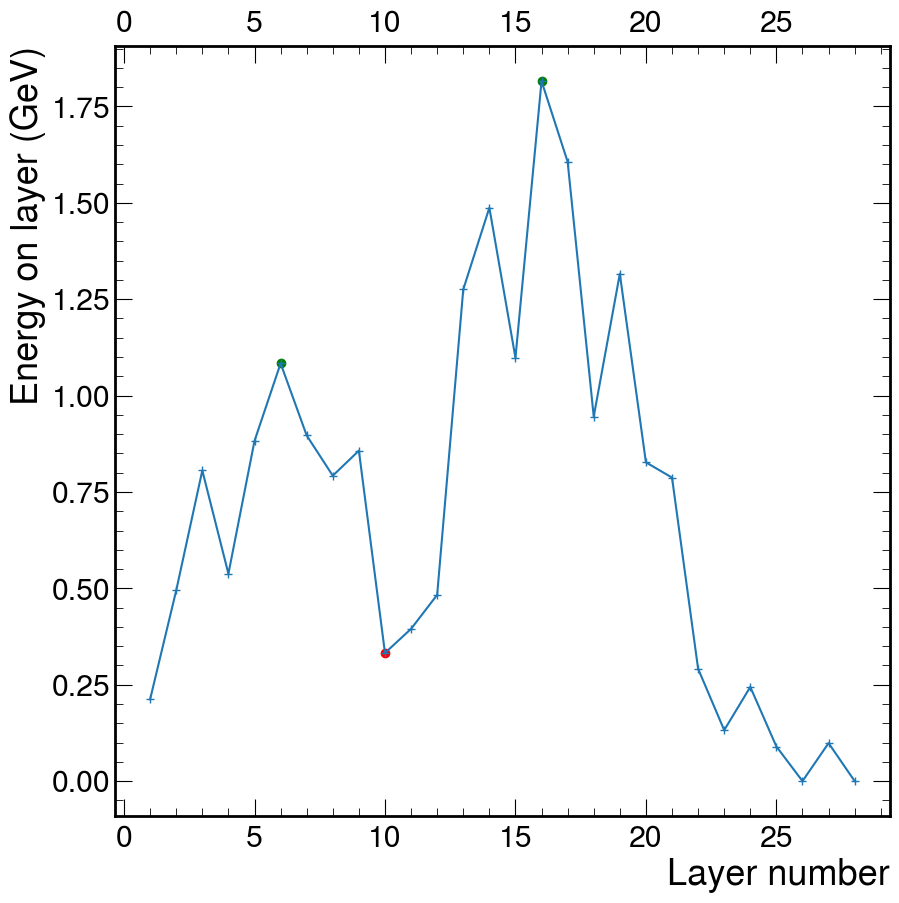

In [21]:
plotIndividualProfile(energySumPerLayer_df, 188, dip_df)

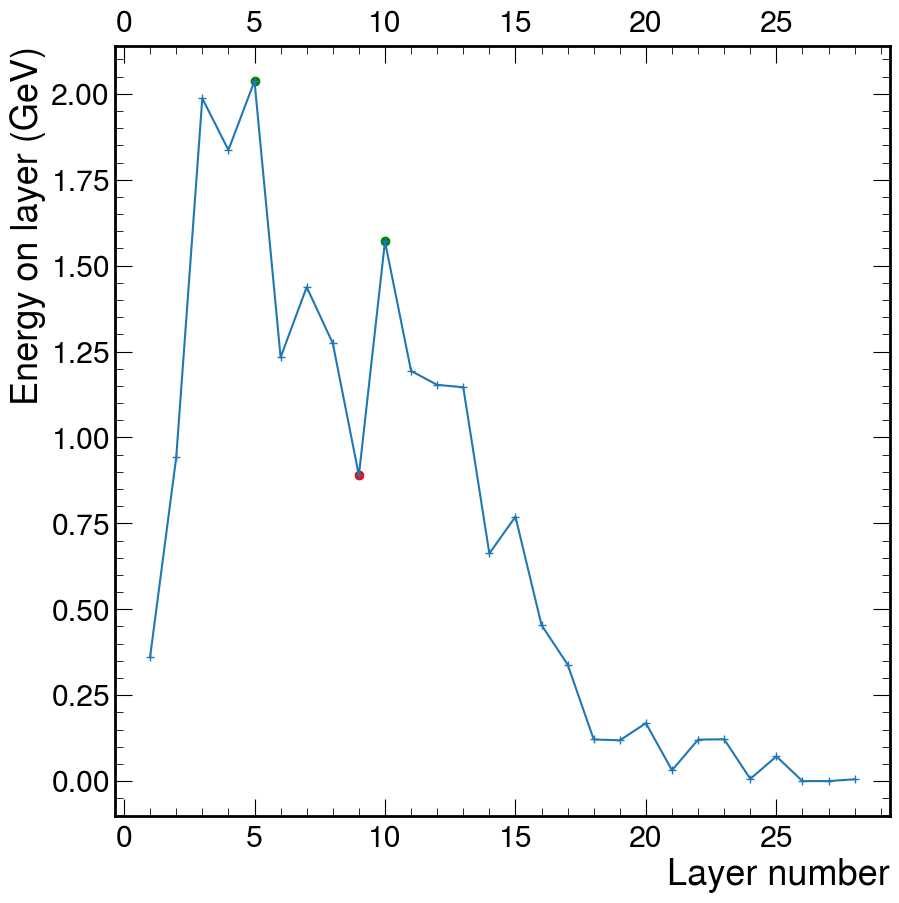

In [15]:
plotIndividualProfile(energySumPerLayer_df, random.choice(dip_df.index), dip_df)

In [16]:
ed = EventDisplay(dip_df, eventLoader, port=8052)

Dash is running on http://127.0.0.1:8052/



In [17]:
from hists.custom_hists import beamEnergiesAxis
h = hist.Hist(beamEnergiesAxis(), hist.axis.Integer(0, 20, name="dipLength", label="Length of dip"), 
              hist.axis.Regular(100, 0., 20., name="dipDepth", label="Dip depth (GeV)"))

In [18]:
h.fill(dip_df.beamEnergy, dip_df.dipLength, dip_df.meanOfMaximasEnergies - dip_df.dip_layer_energy)

Hist(
  IntCategory([20, 30, 50, 80, 100, 120, 150, 200, 250, 300], name='beamEnergy', label='Beam energy (GeV)'),
  Integer(0, 20, name='dipLength', label='Length of dip'),
  Regular(100, 0, 20, name='dipDepth', label='Dip depth (GeV)'),
  storage=Double()) # Sum: 271.0

(0.0, 3.0)

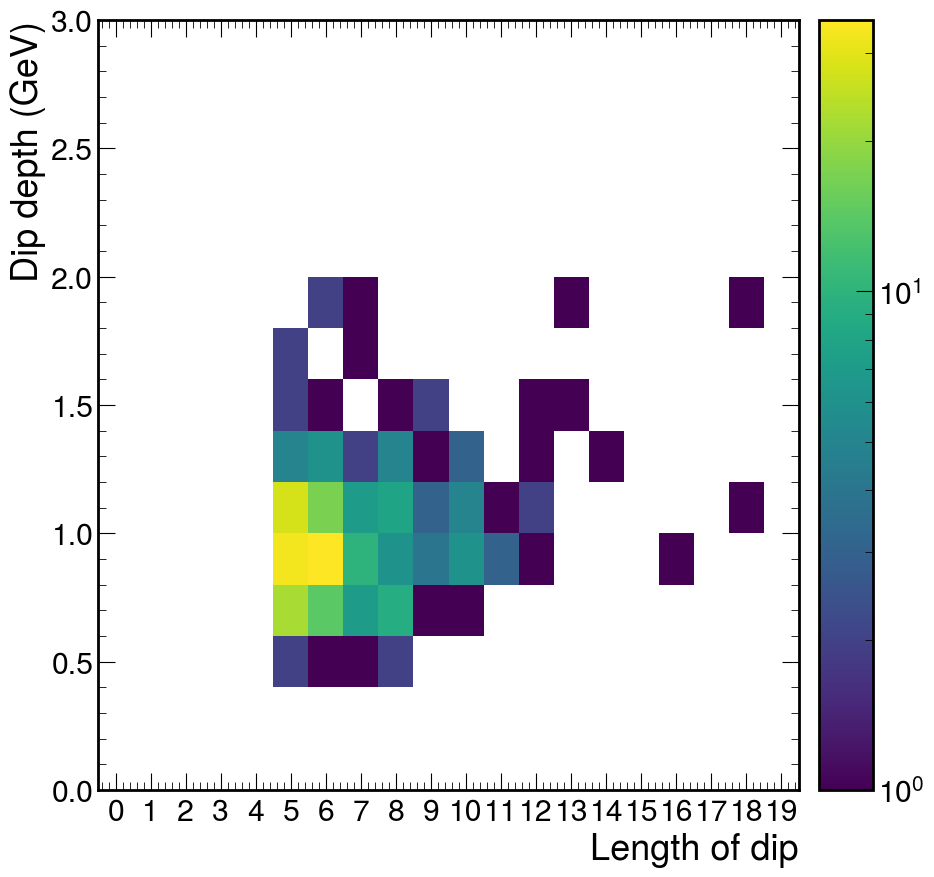

In [19]:
hep.hist2dplot(h[{"beamEnergy":hist.loc(20)}], norm=matplotlib.colors.LogNorm())
plt.ylim(0, 3)